# Red Neuronal para Predicción de Revenue

In [1]:
%pip install pyarrow torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# Configurar dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [2]:
# Configurar ruta y cargar subset pequeño de datos
train_path = '/home/stargix/Desktop/hackathons/datathon/train/train'

# Obtener lista de archivos parquet
parquet_files = glob(os.path.join(train_path, '**/part-*.parquet'), recursive=True)
print(f"Total de archivos parquet: {len(parquet_files)}")

# Usar solo los primeros 5 archivos para entrenar (subset pequeño)
sample_files = parquet_files[:5]
print(f"Usando {len(sample_files)} archivos para entrenamiento")

# Cargar y combinar datos
dfs = []
for file in sample_files:
    df = pd.read_parquet(file)
    dfs.append(df)
    print(f"Cargado: {os.path.basename(os.path.dirname(file))}, shape: {df.shape}")

data = pd.concat(dfs, ignore_index=True)
print(f"\nDatos combinados - Shape: {data.shape}")
print(f"Columnas: {data.columns.tolist()}")
print(f"\nPrimeras filas:\n{data.head()}")
print(f"\nInfo de tipos:\n{data.dtypes}")
print(f"\nValores faltantes:\n{data.isnull().sum()}")

Total de archivos parquet: 144
Usando 5 archivos para entrenamiento
Cargado: datetime=2025-10-01-09-00, shape: (129498, 84)
Cargado: datetime=2025-10-01-09-00, shape: (129498, 84)
Cargado: datetime=2025-10-01-15-00, shape: (168080, 84)
Cargado: datetime=2025-10-01-15-00, shape: (168080, 84)
Cargado: datetime=2025-10-02-04-00, shape: (123229, 84)
Cargado: datetime=2025-10-02-04-00, shape: (123229, 84)
Cargado: datetime=2025-10-06-13-00, shape: (157391, 84)
Cargado: datetime=2025-10-06-13-00, shape: (157391, 84)
Cargado: datetime=2025-10-01-16-00, shape: (170026, 84)
Cargado: datetime=2025-10-01-16-00, shape: (170026, 84)

Datos combinados - Shape: (748224, 84)
Columnas: ['buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28', 'buy_d7', 'buy_d14', 'buy_d28', 'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28', 'registration', 'retention_d1_to_d7', 'retention_d3_to_d7', 'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retentiond7', 'advertiser_bundle', 'advertiser_category', 'advertis

In [6]:
# Preparar datos para la red neuronal
# Separar features y target (asumiendo que 'revenue' es el target)

# Seleccionar features numéricos
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Identificar la columna target (revenue)
if 'iap_revenue_d7' in numeric_cols:
    target_col = 'iap_revenue_d7'
    feature_cols = [col for col in numeric_cols if col != 'iap_revenue_d7']
else:
    print("Columnas disponibles:", numeric_cols)
    target_col = numeric_cols[-1]
    feature_cols = numeric_cols[:-1]

print(f"Target: {target_col}")
print(f"Features ({len(feature_cols)}): {feature_cols}")

# Preparar X (features) e y (target)
X = data[feature_cols].values.astype(np.float32)
y = data[target_col].values.astype(np.float32)

print(f"\nShape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"Rango de revenue: [{y.min():.2f}, {y.max():.2f}]")

Target: iap_revenue_d7
Features (26): ['buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28', 'buy_d7', 'buy_d14', 'buy_d28', 'iap_revenue_d14', 'iap_revenue_d28', 'registration', 'retention_d1_to_d7', 'retention_d3_to_d7', 'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retentiond7', 'release_msrp', 'weekday', 'avg_act_days', 'avg_days_ins', 'first_request_ts', 'last_buy', 'last_ins', 'weekend_ratio', 'weeks_since_first_seen', 'wifi_ratio']

Shape de X: (748224, 26)
Shape de y: (748224,)
Rango de revenue: [0.00, 861191.12]


Columnas numéricas: ['buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28', 'buy_d7', 'buy_d14', 'buy_d28', 'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28', 'registration', 'retention_d1_to_d7', 'retention_d3_to_d7', 'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retentiond7', 'release_msrp', 'weekday', 'avg_act_days', 'avg_days_ins', 'first_request_ts', 'last_buy', 'last_ins', 'weekend_ratio', 'weeks_since_first_seen', 'wifi_ratio']


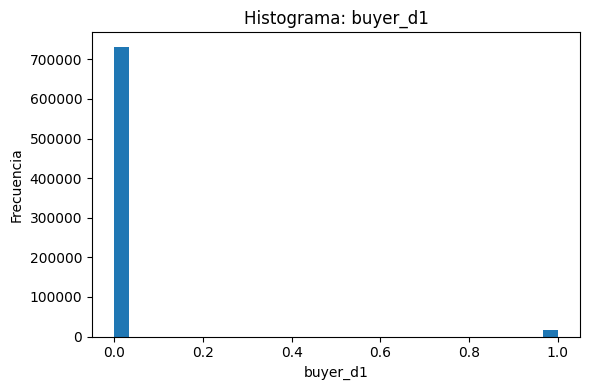

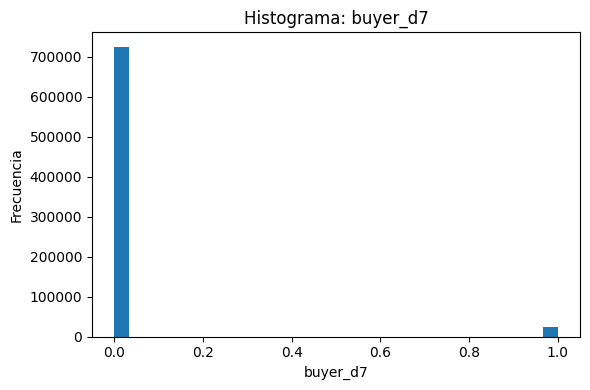

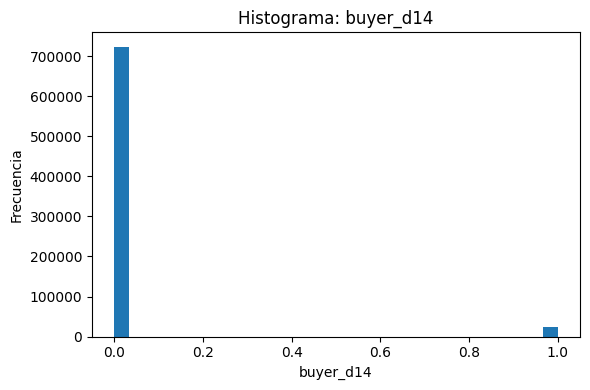

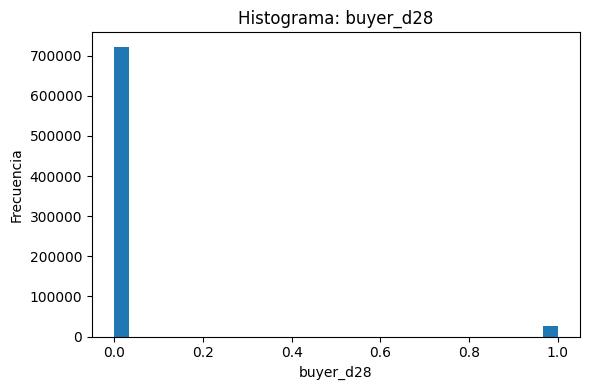

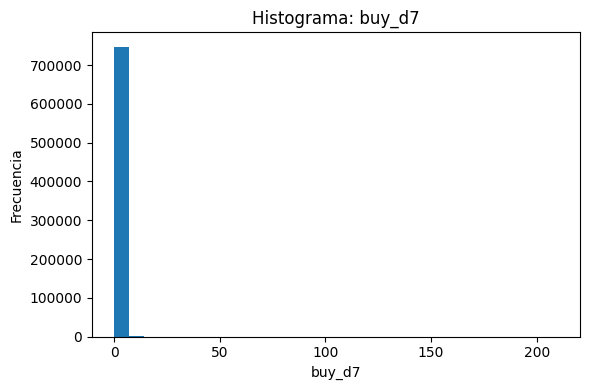

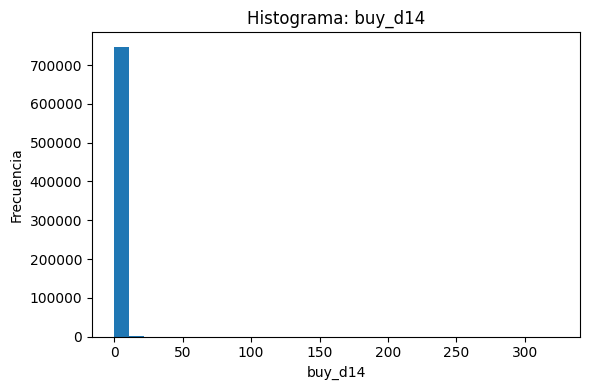

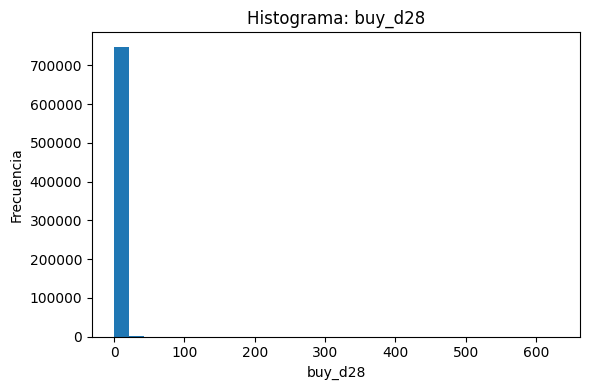

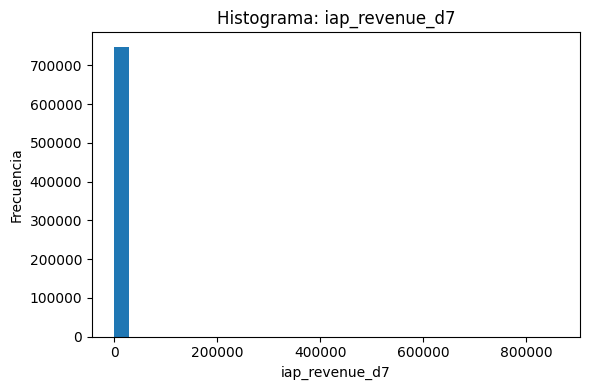

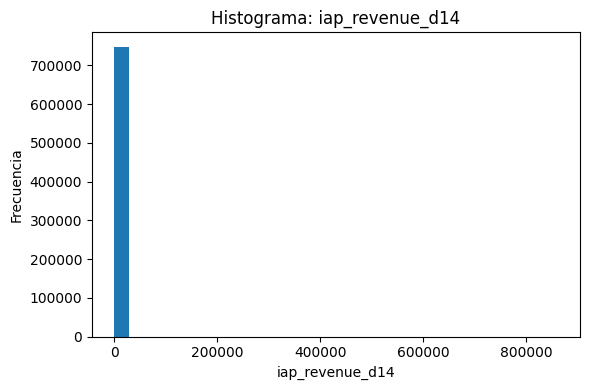

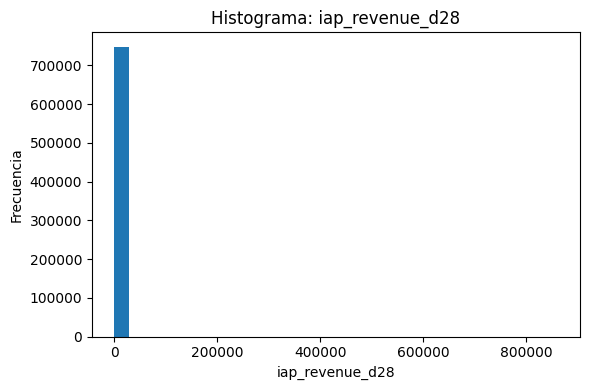

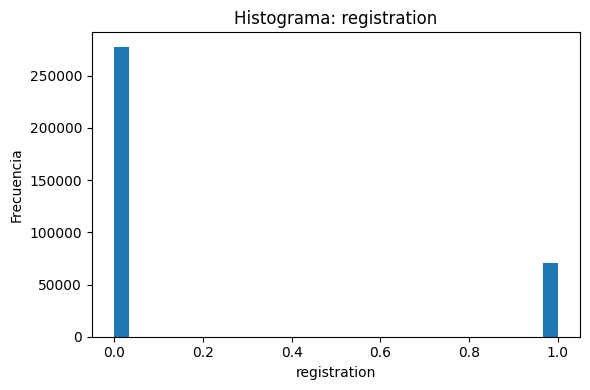

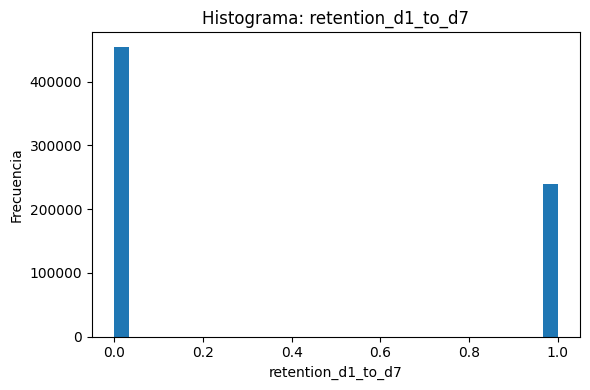

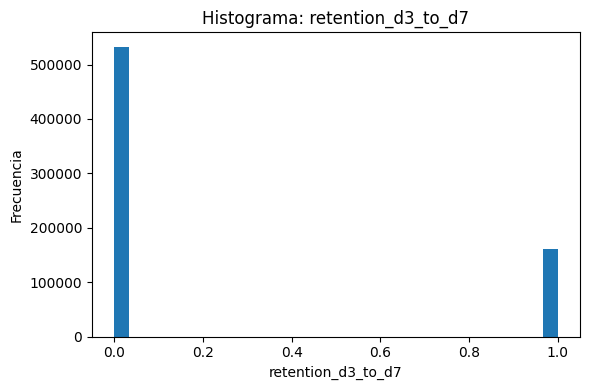

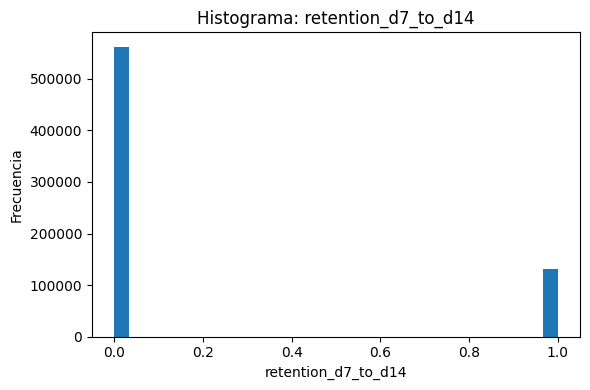

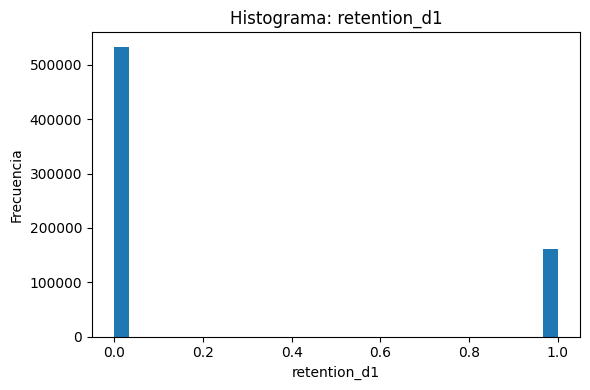

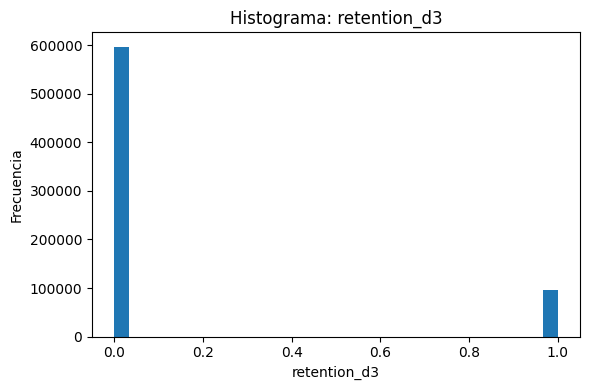

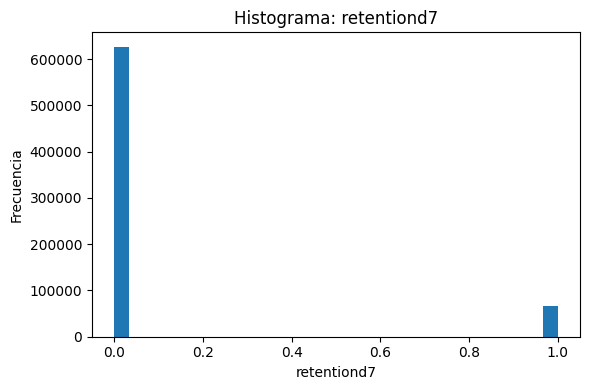

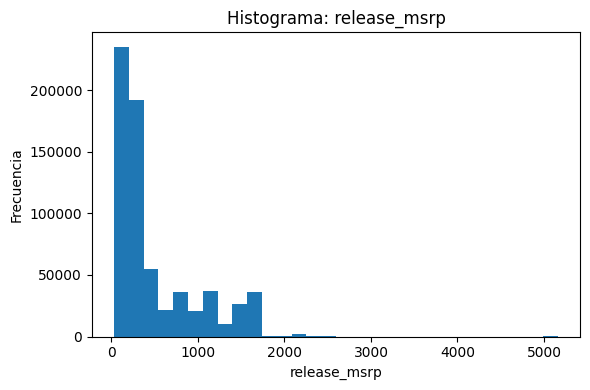

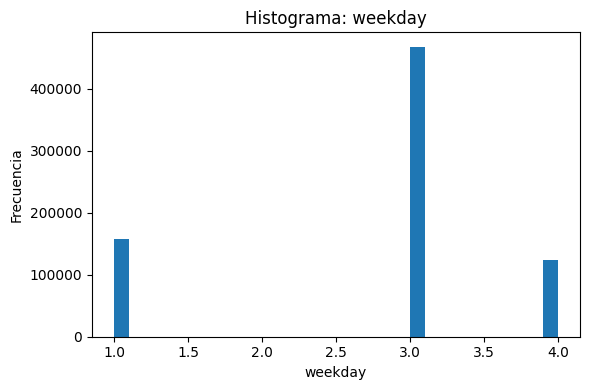

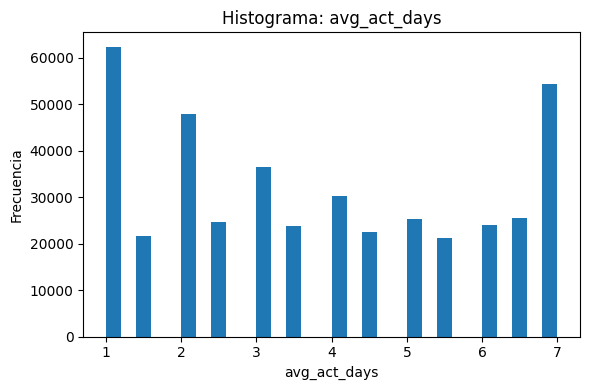

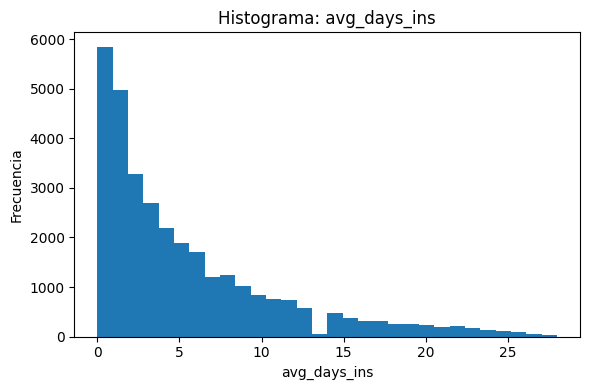

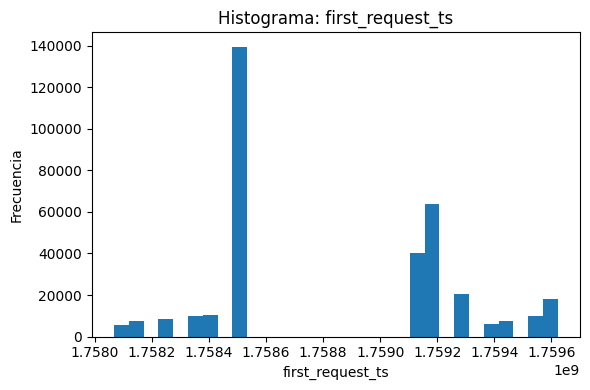

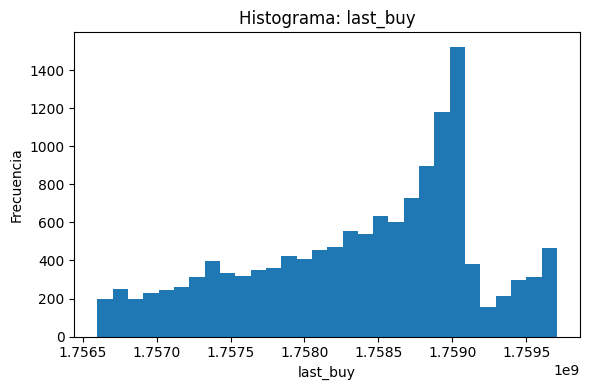

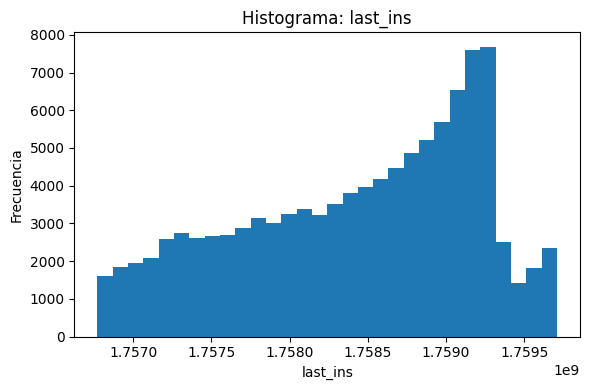

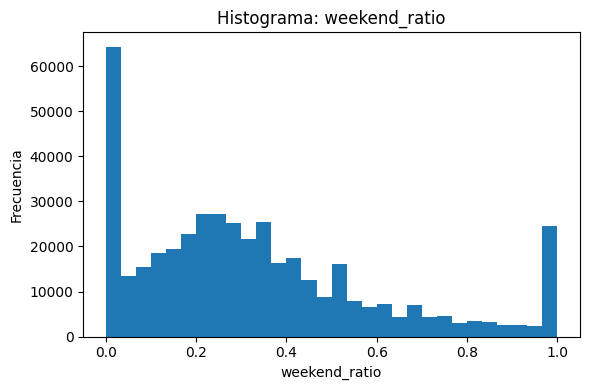

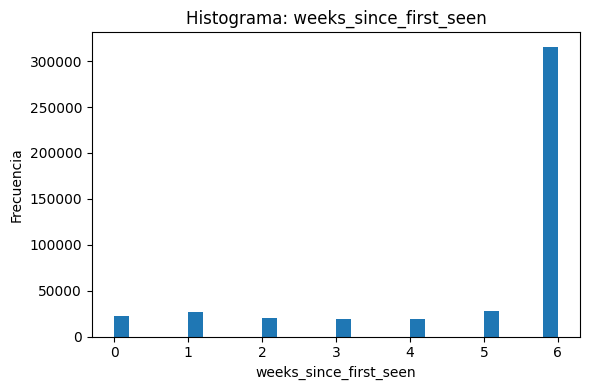

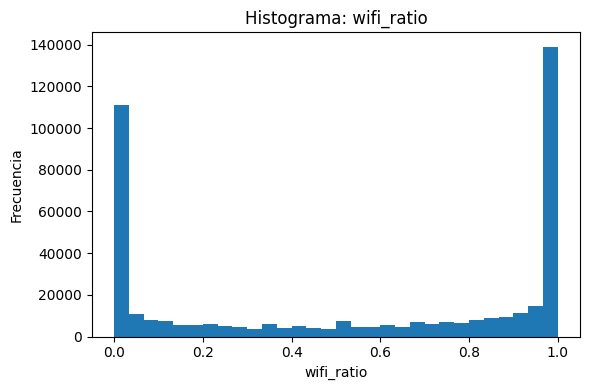

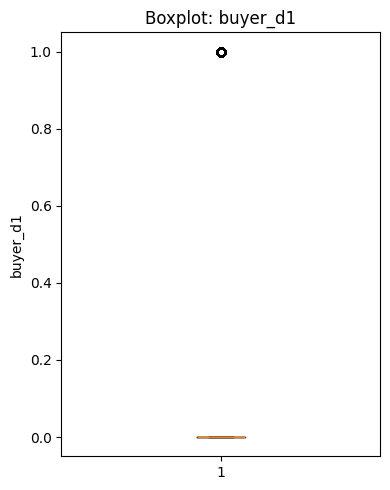

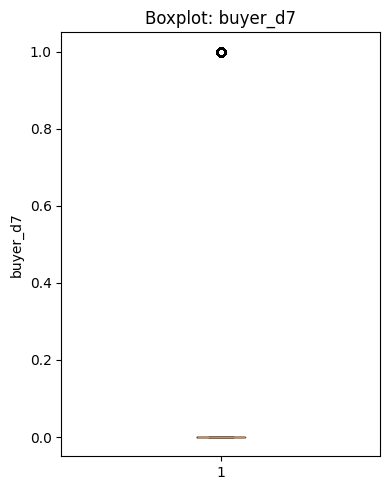

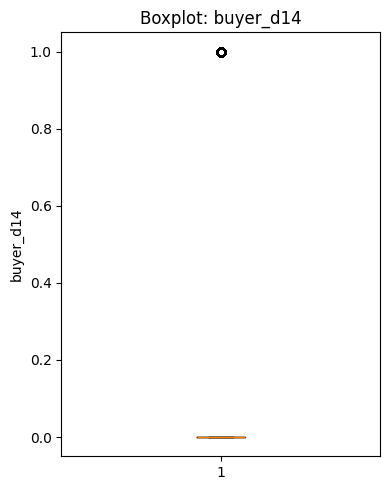

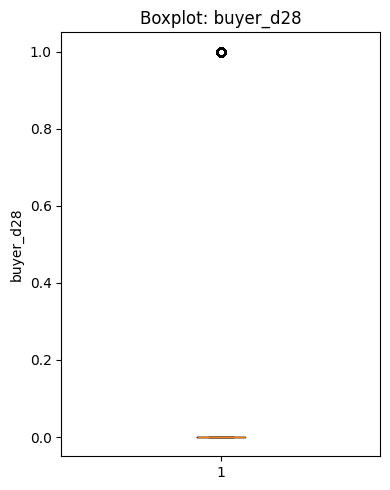

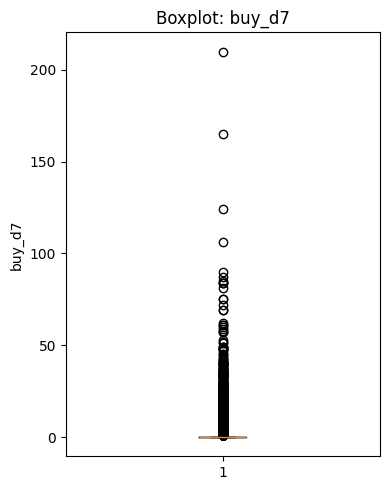

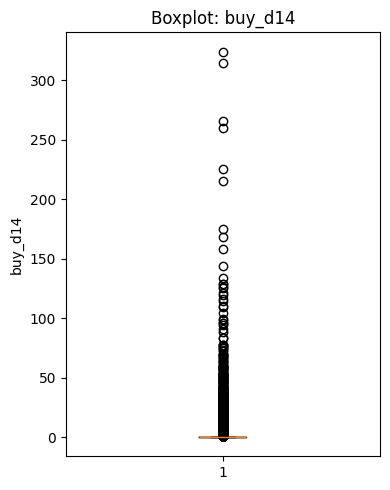

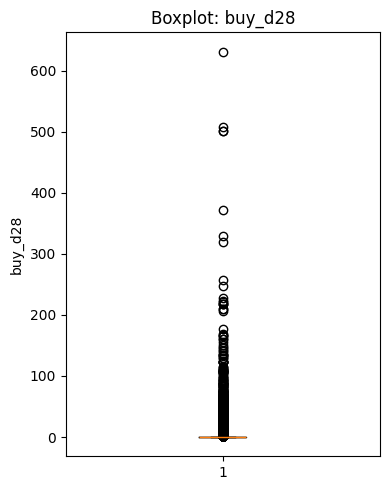

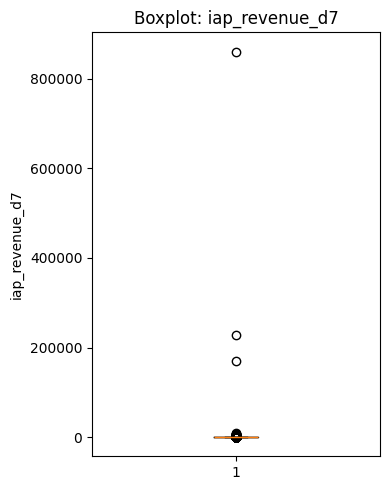

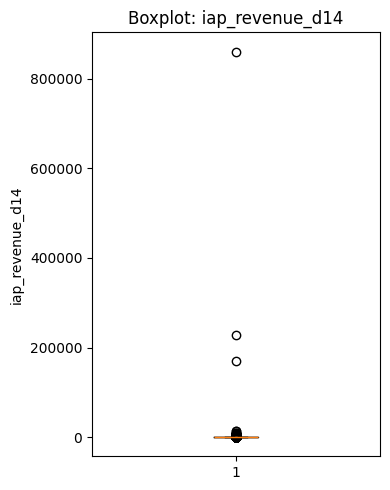

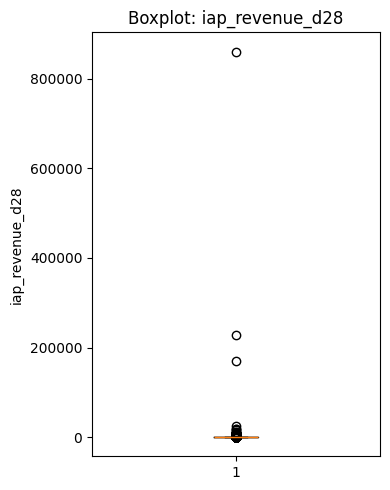

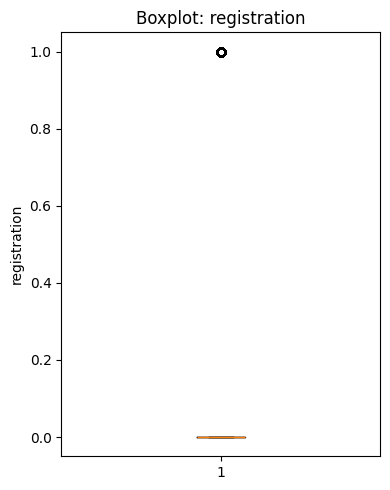

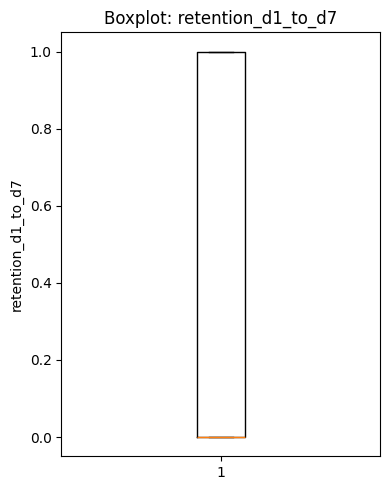

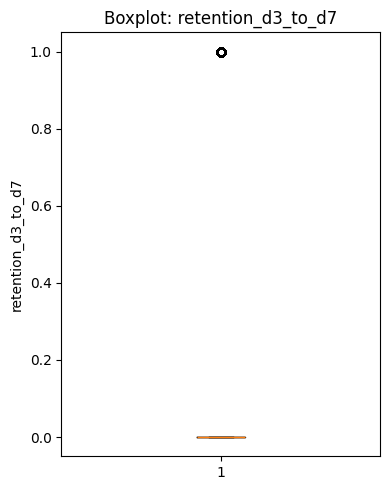

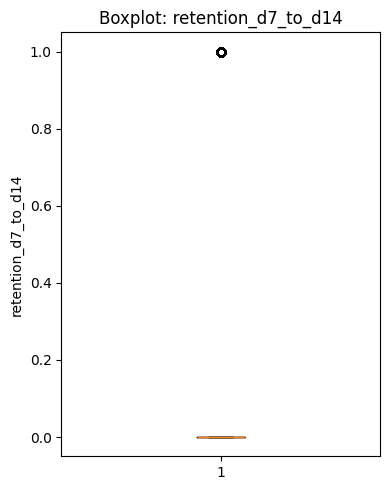

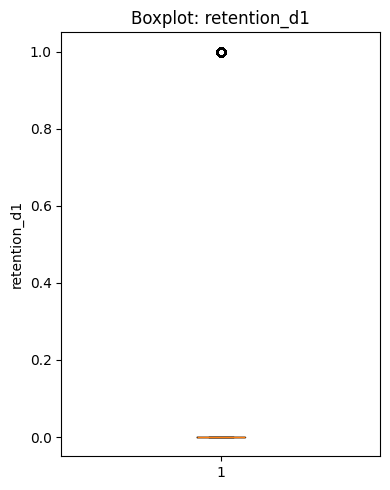

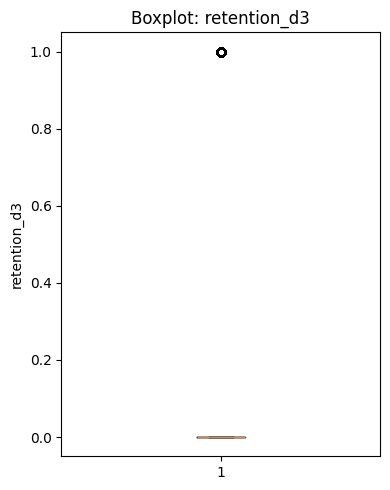

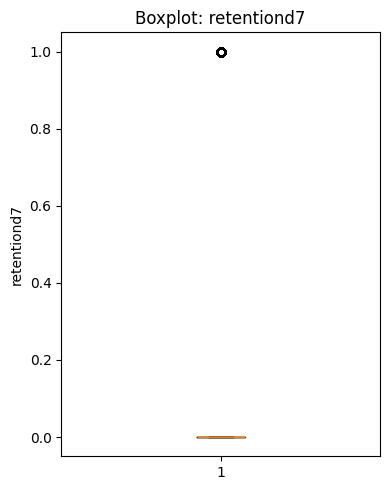

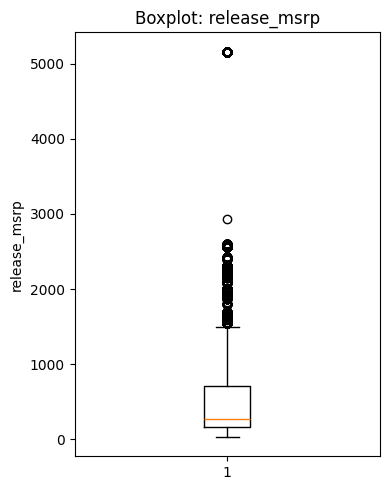

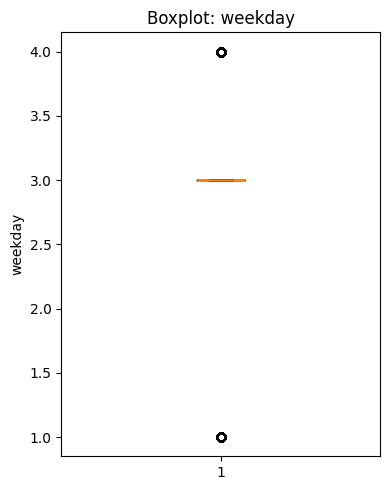

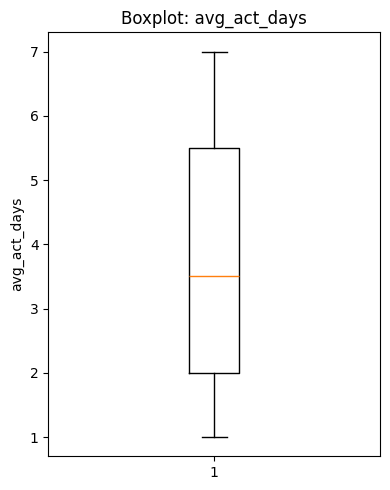

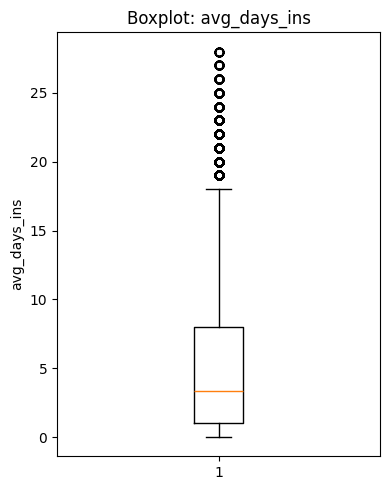

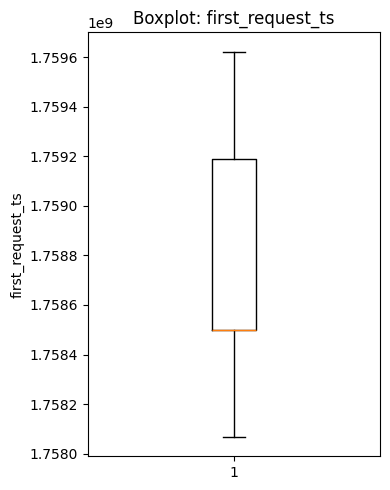

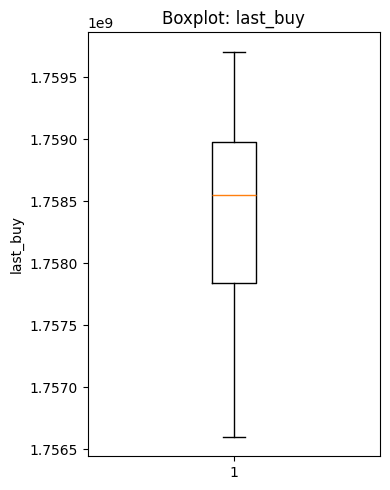

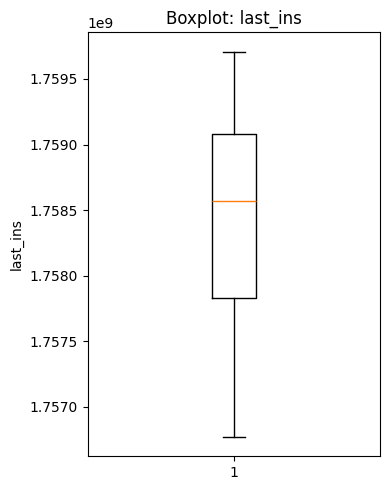

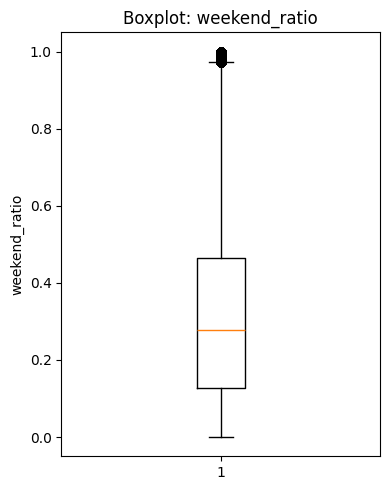

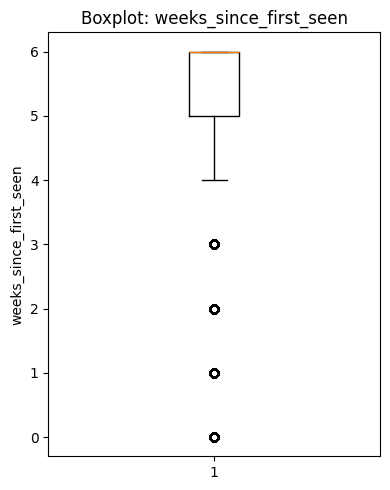

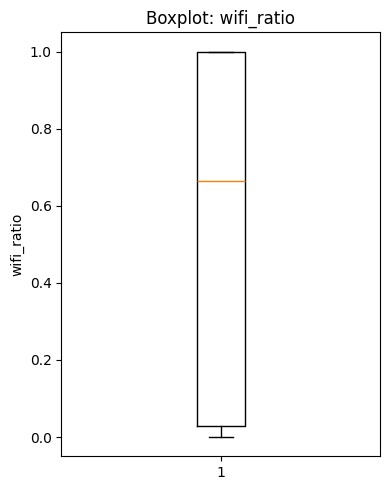

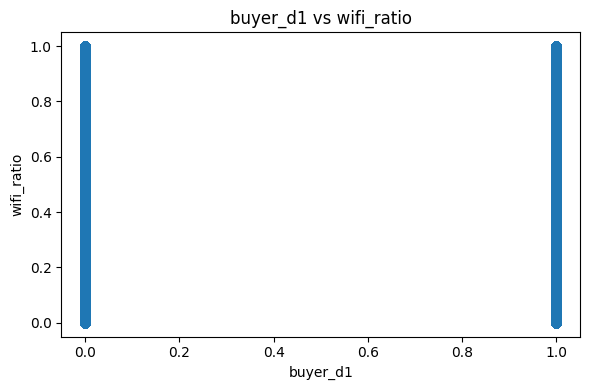

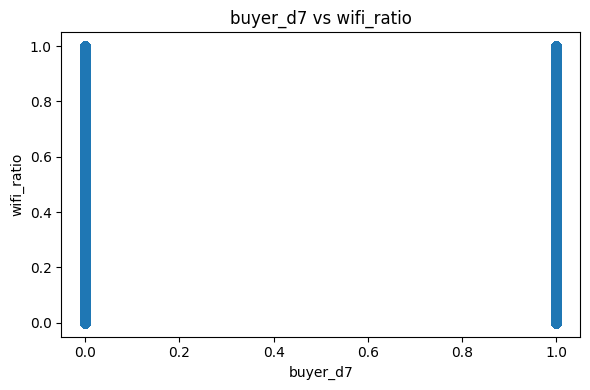

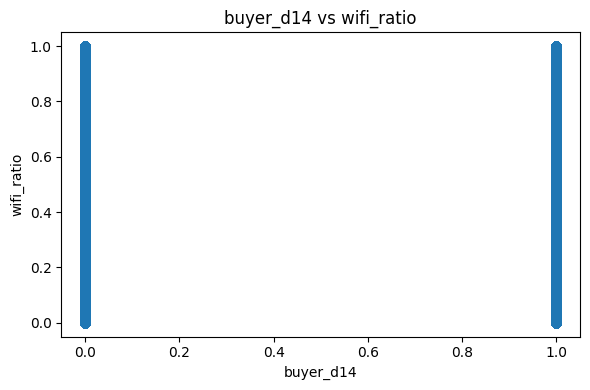

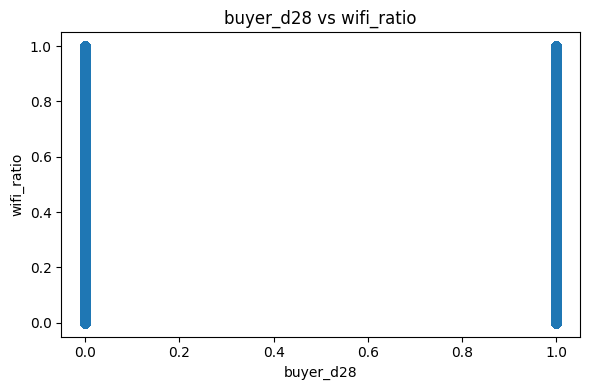

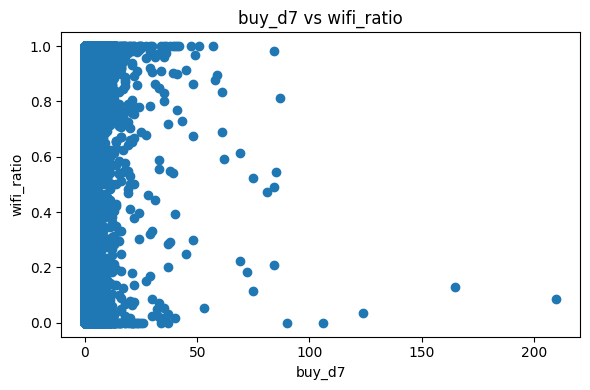

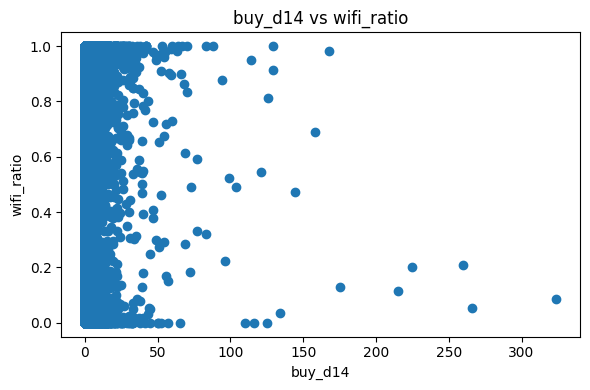

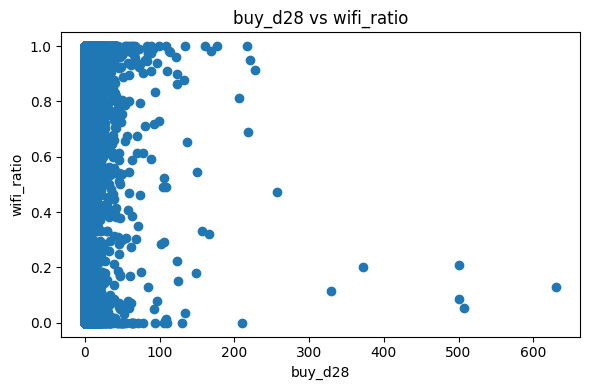

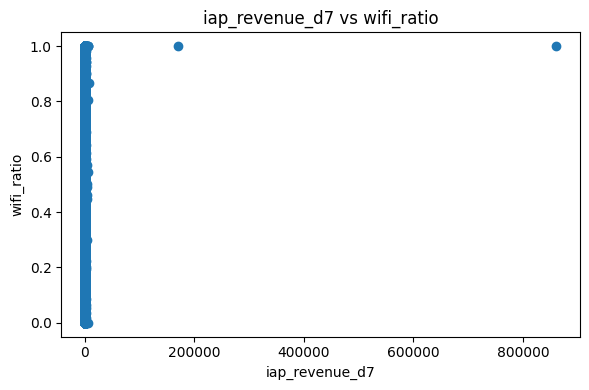

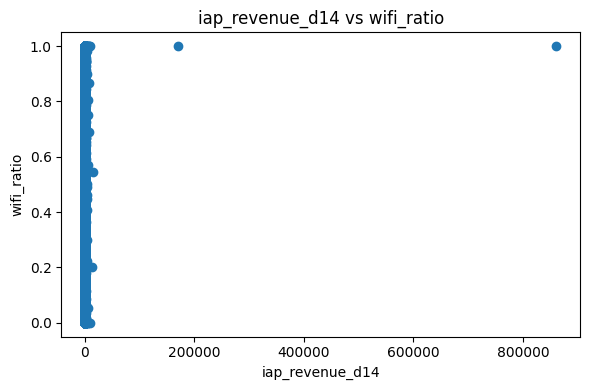

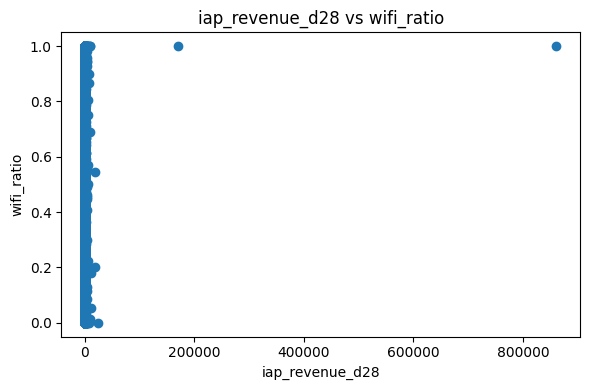

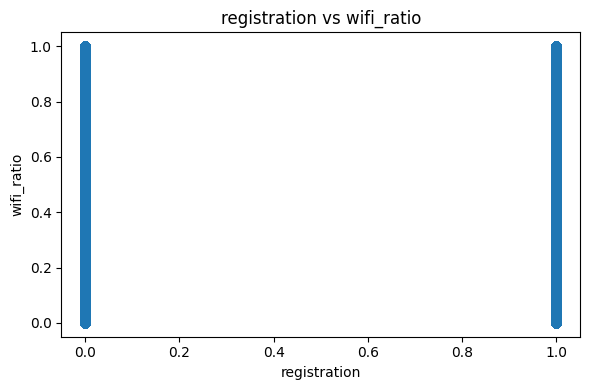

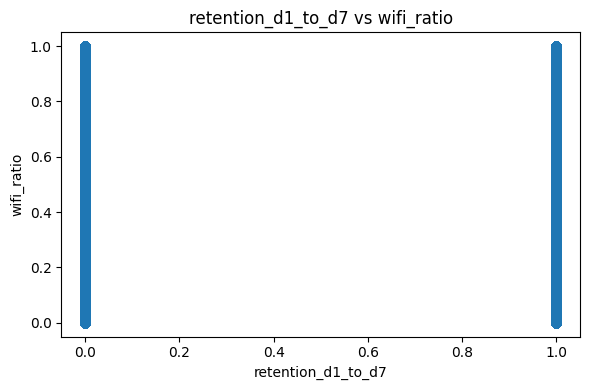

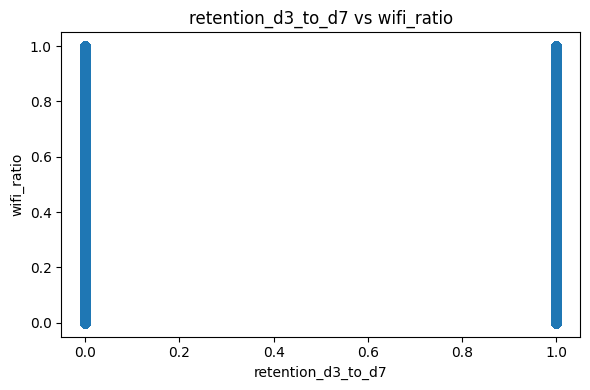

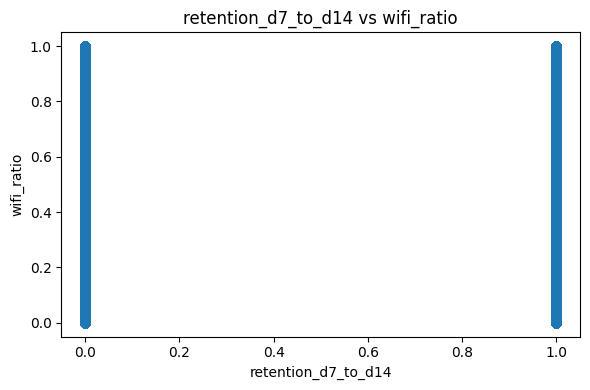

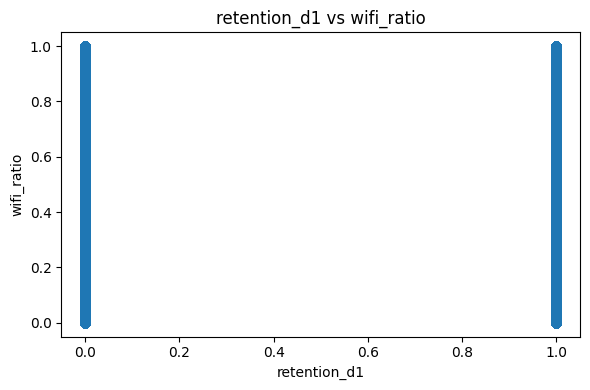

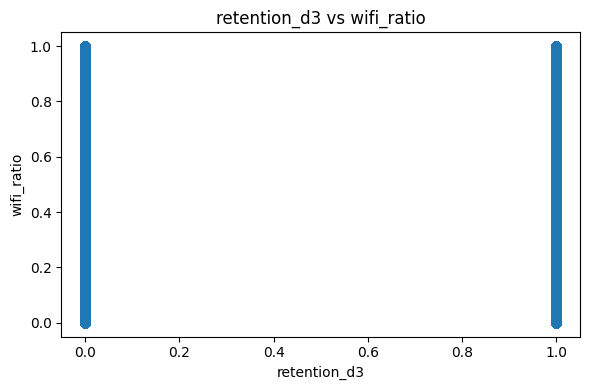

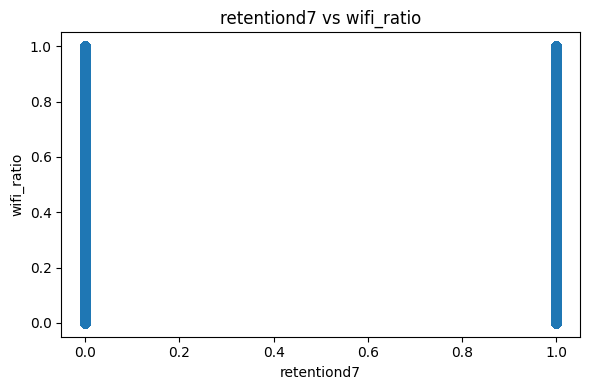

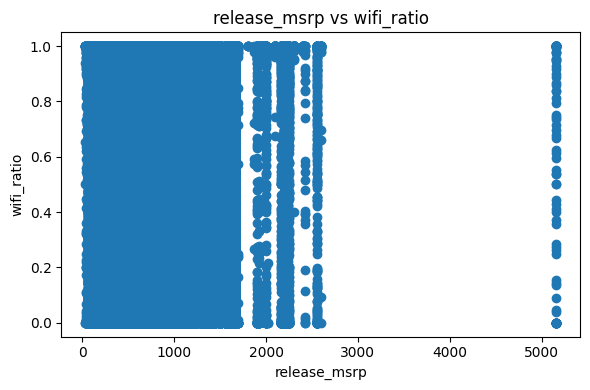

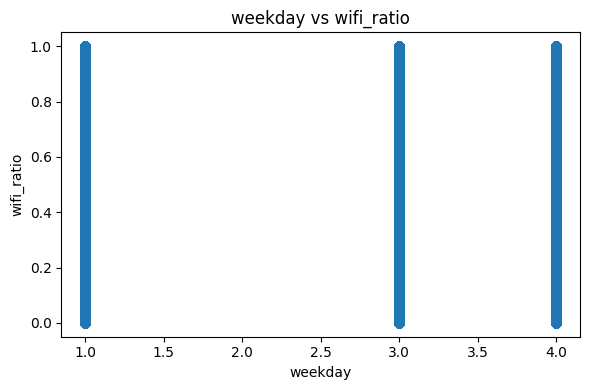

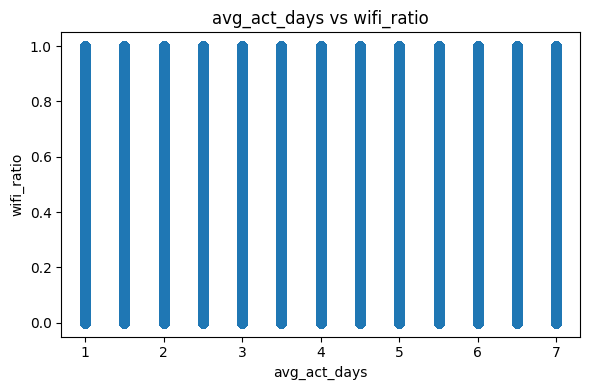

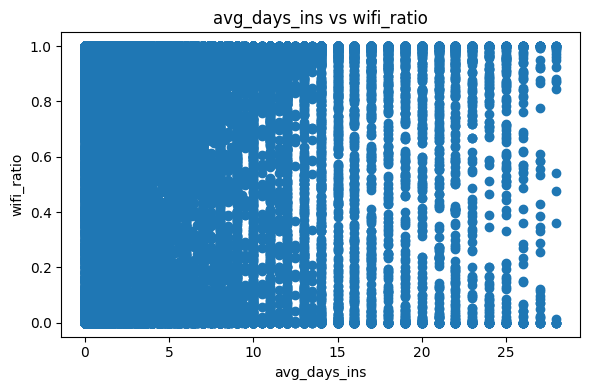

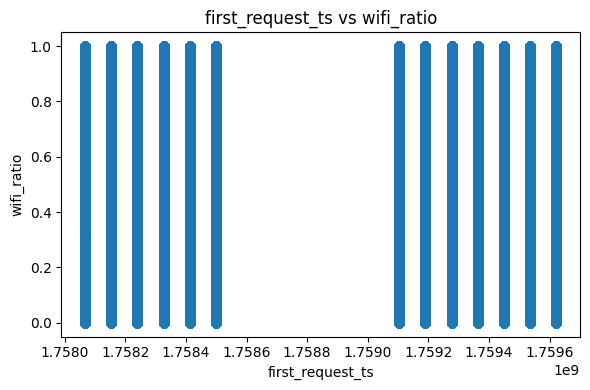

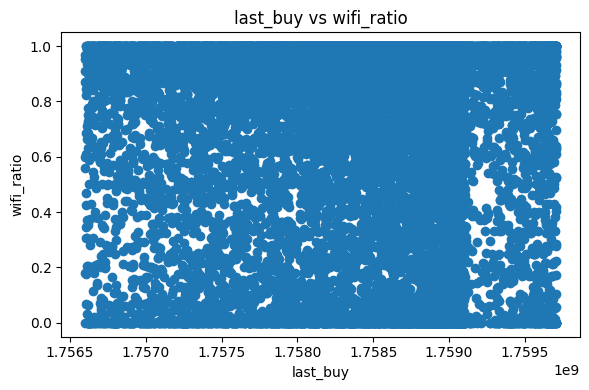

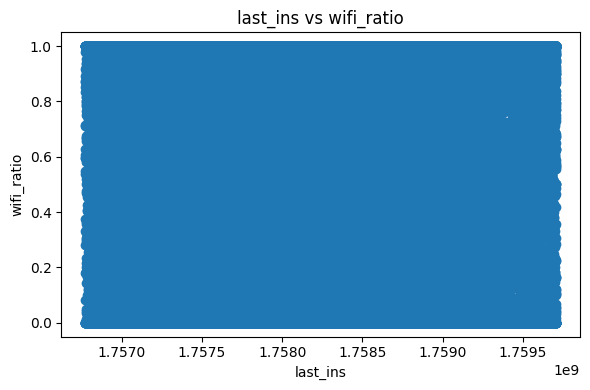

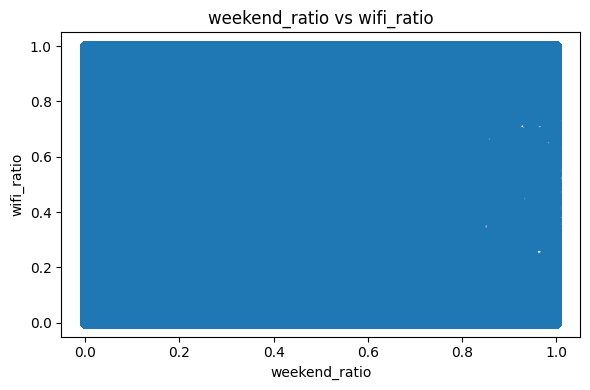

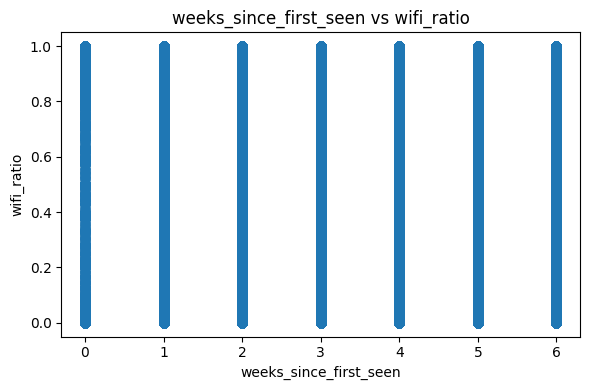

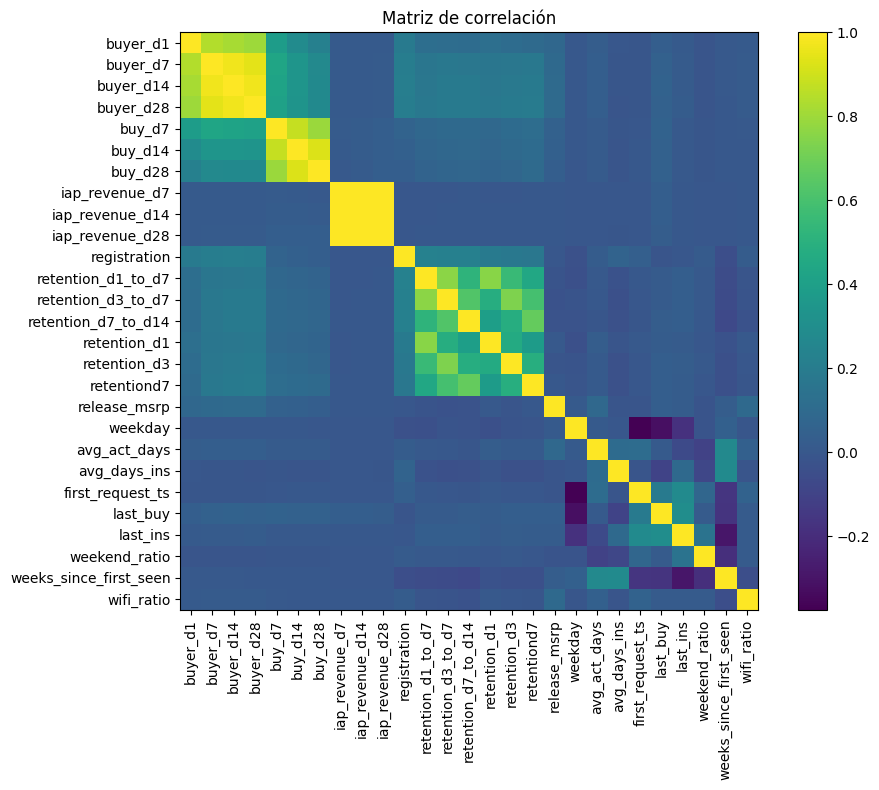

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar columnas numéricas
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

print("Columnas numéricas:", numeric_cols)

# ================================
# 1. Histograma de cada variable
# ================================
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.hist(data[col].dropna(), bins=30)
    plt.title(f"Histograma: {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# =====================================
# 2. Boxplot para detectar outliers
# =====================================
for col in numeric_cols:
    plt.figure(figsize=(4,5))
    plt.boxplot(data[col].dropna(), vert=True)
    plt.title(f"Boxplot: {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# ==========================================
# 3. Scatterplots contra el target (revenue)
# ==========================================
target = "revenue" if "revenue" in numeric_cols else numeric_cols[-1]
features = [c for c in numeric_cols if c != target]

for col in features:
    plt.figure(figsize=(6,4))
    plt.scatter(data[col], data[target])
    plt.title(f"{col} vs {target}")
    plt.xlabel(col)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

# ===================================
# 4. Matriz de correlación (heatmap)
# ===================================
corr = data[numeric_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.title("Matriz de correlación")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()


Total de archivos parquet en test: 96
Cargado: datetime=2025-10-08-13-00, shape: (151928, 67)
Cargado: datetime=2025-10-08-13-00, shape: (151928, 67)
Cargado: datetime=2025-10-11-18-00, shape: (162609, 67)
Cargado: datetime=2025-10-11-18-00, shape: (162609, 67)
Cargado: datetime=2025-10-11-23-00, shape: (117016, 67)

Datos de test combinados - Shape: (431553, 67)
Columnas: ['advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'advertiser_bottom_taxonomy_level', 'carrier', 'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv', 'hour', 'release_date', 'release_msrp', 'weekday', 'avg_act_days', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration', 'bcat', 'bcat_bottom_taxonomy', 'bundles_cat', 'bundles_cat_bottom_taxonomy', 'bundles_ins', 'city_hist', 'country_hist', 'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk', 'dev_language_hist', 'dev_osv_hist', 'first_request_ts', 'first_request_ts_bundle', 'first_request_ts_category_bottom_taxonomy', 'hour_ratio', 'iap_revenu

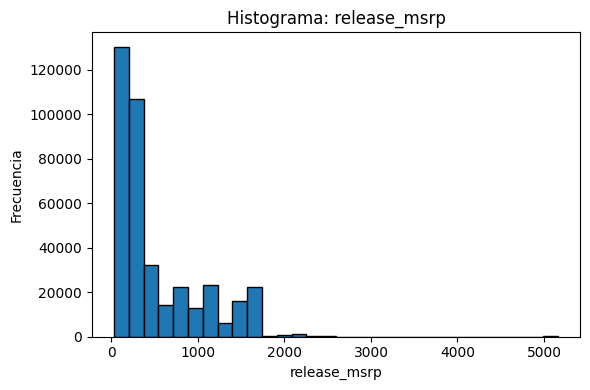

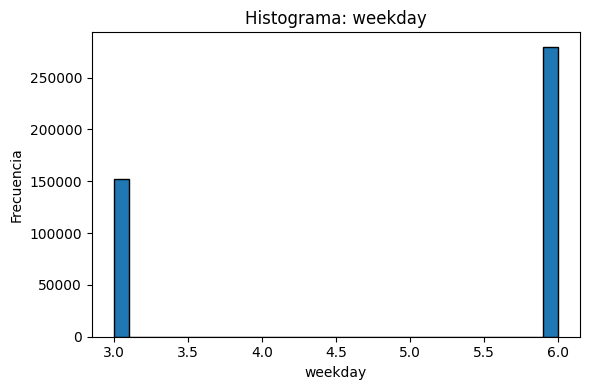

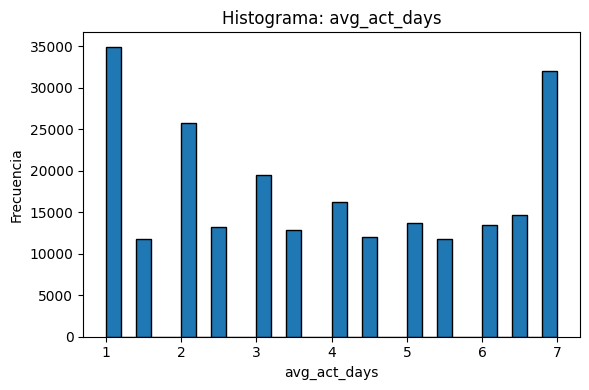

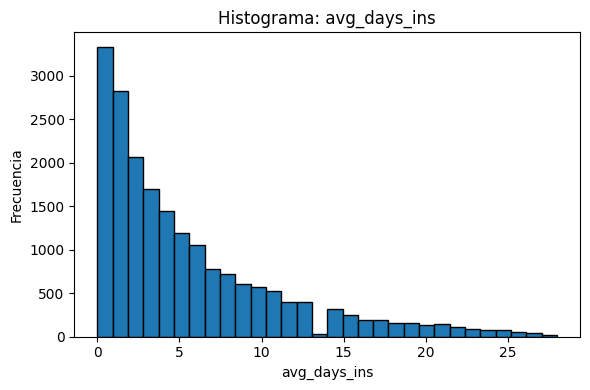

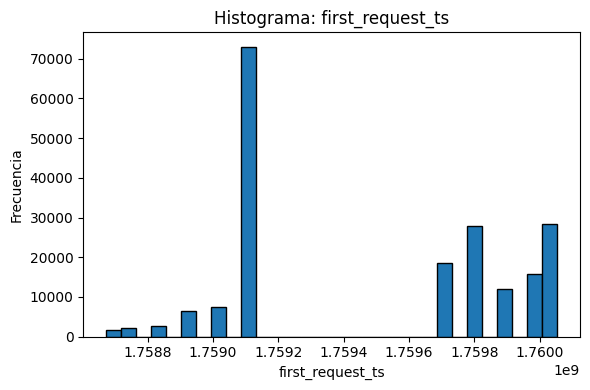

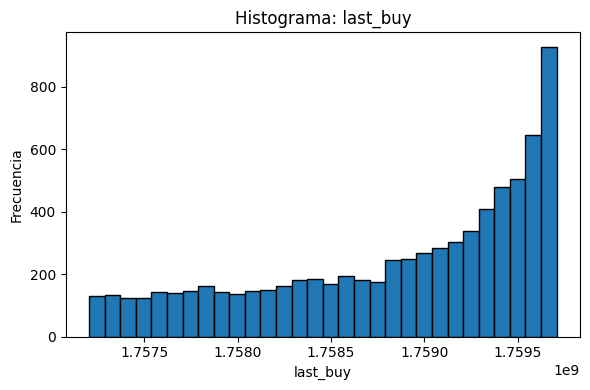

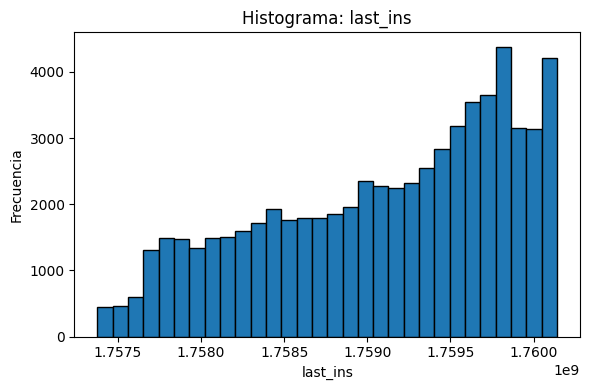

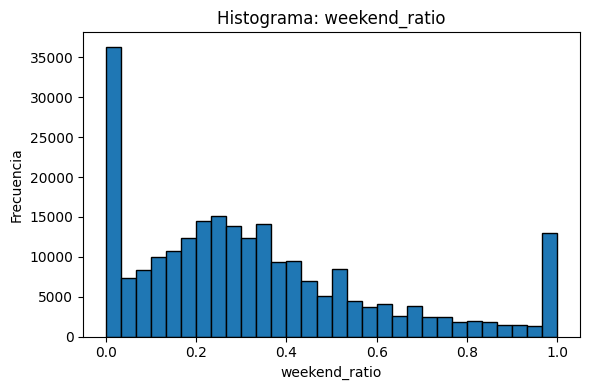

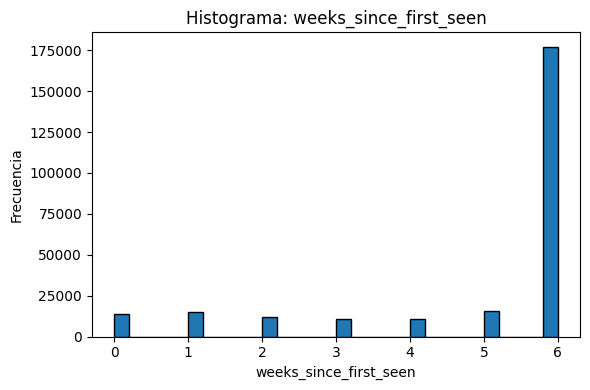

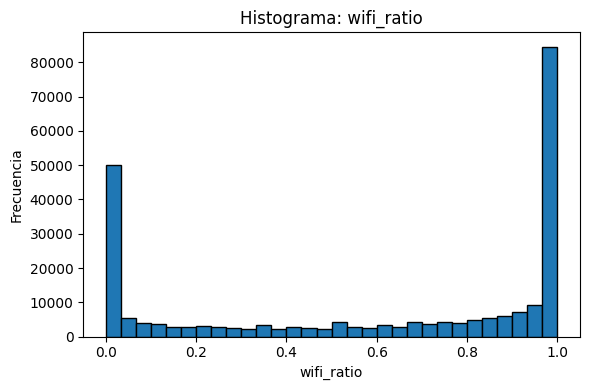

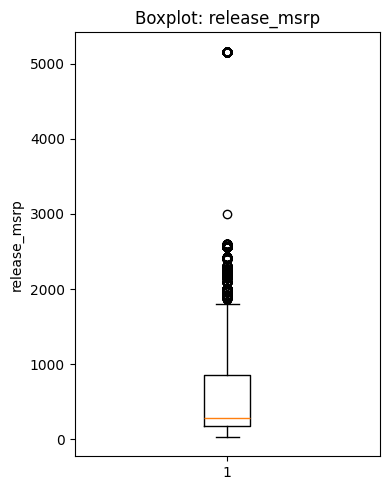

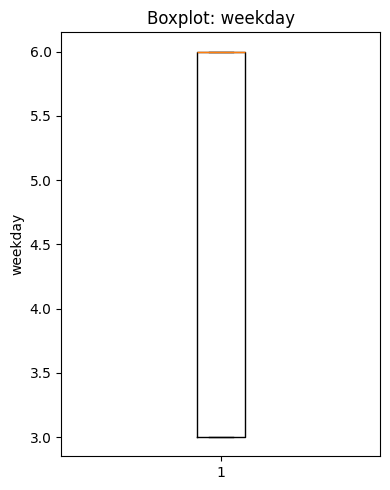

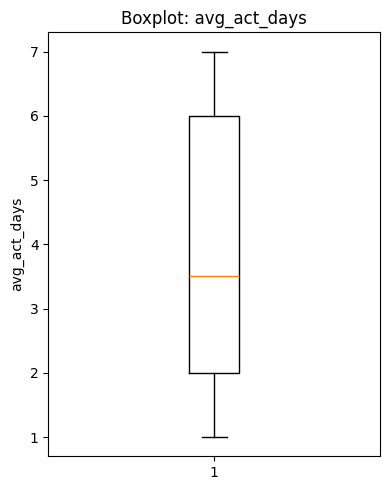

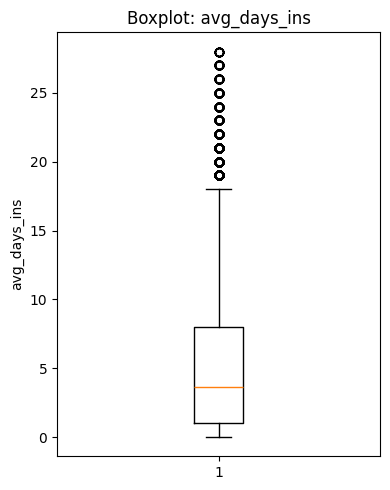

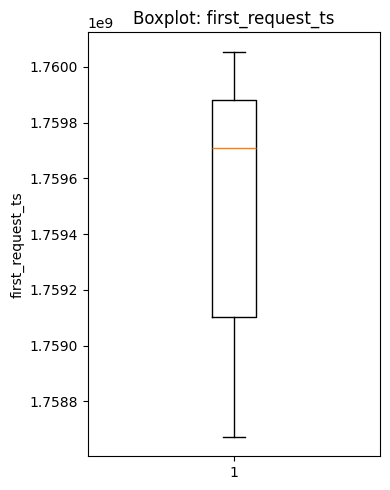

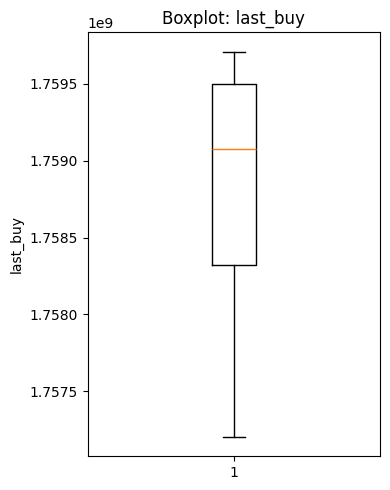

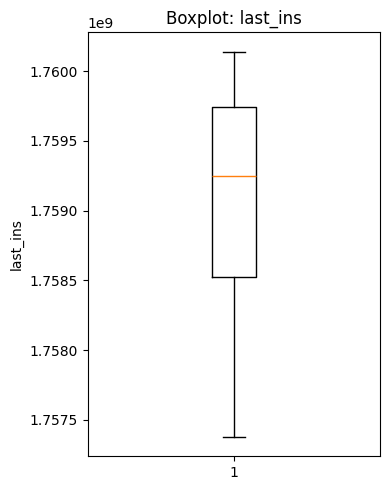

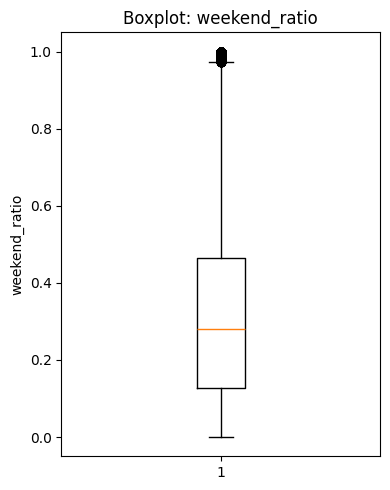

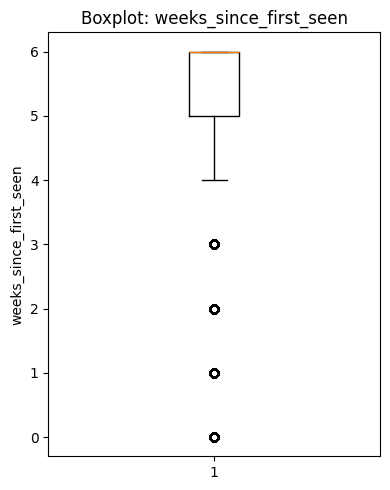

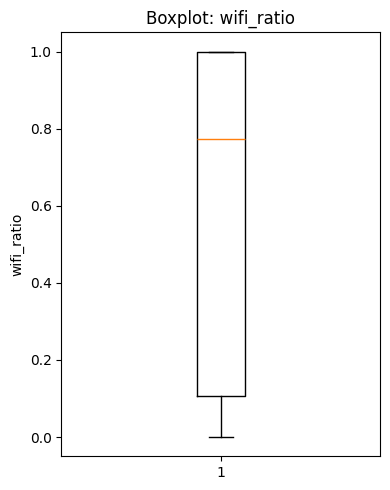


Estadísticas descriptivas del test:
        release_msrp        weekday   avg_act_days  avg_days_ins  \
count  389228.000000  431553.000000  231914.000000  19669.000000   
mean      519.563695       4.943852       3.850449      5.486026   
std       494.790086       1.432830       2.092652      5.715790   
min        30.000000       3.000000       1.000000      0.000000   
25%       170.000000       3.000000       2.000000      1.000000   
50%       280.000000       6.000000       3.500000      3.600000   
75%       849.000000       6.000000       6.000000      8.000000   
max      5160.000000       6.000000       7.000000     28.000000   

       first_request_ts      last_buy      last_ins  weekend_ratio  \
count      1.958770e+05  7.577000e+03  6.434800e+04  240816.000000   
mean       1.759495e+09  1.758857e+09  1.759106e+09       0.330261   
std        4.274787e+05  7.267696e+05  7.373246e+05       0.272183   
min        1.758672e+09  1.757203e+09  1.757377e+09       0.000000   


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import os

# Configurar ruta al dataset de test
test_path = '/home/stargix/Desktop/hackathons/datathon/test/test'

# Obtener lista de archivos parquet
parquet_files = glob(os.path.join(test_path, '**/part-*.parquet'), recursive=True)
print(f"Total de archivos parquet en test: {len(parquet_files)}")

# Cargar algunos archivos para análisis (primeros 3)
sample_files = parquet_files[:3]
dfs = []
for file in sample_files:
    df = pd.read_parquet(file)
    dfs.append(df)
    print(f"Cargado: {os.path.basename(os.path.dirname(file))}, shape: {df.shape}")

test_data = pd.concat(dfs, ignore_index=True)
print(f"\nDatos de test combinados - Shape: {test_data.shape}")
print(f"Columnas: {test_data.columns.tolist()}")
print(f"\nPrimeras filas:\n{test_data.head()}")
print(f"\nInfo de tipos:\n{test_data.dtypes}")
print(f"\nValores faltantes:\n{test_data.isnull().sum()}")

# ================================
# Análisis exploratorio de test
# ================================
numeric_cols_test = test_data.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nColumnas numéricas en test: {numeric_cols_test}")

# 1. Histogramas
for col in numeric_cols_test:
    plt.figure(figsize=(6,4))
    plt.hist(test_data[col].dropna(), bins=30, edgecolor='black')
    plt.title(f"Histograma: {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# 2. Boxplots para detectar outliers
for col in numeric_cols_test:
    plt.figure(figsize=(4,5))
    plt.boxplot(test_data[col].dropna(), vert=True)
    plt.title(f"Boxplot: {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# 3. Estadísticas descriptivas
print("\nEstadísticas descriptivas del test:")
print(test_data[numeric_cols_test].describe())

In [9]:
# Normalizar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Shape de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Shape de prueba: {X_test.shape}, {y_test.shape}")

# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1).to(device)

# Crear DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"\nTensores creados en dispositivo: {device}")

Shape de entrenamiento: (598579, 26), (598579,)
Shape de prueba: (149645, 26), (149645,)

Tensores creados en dispositivo: cuda


In [10]:
# Definir arquitectura de red neuronal con PyTorch
class RevenueNN(nn.Module):
    def __init__(self, input_dim):
        super(RevenueNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(32, 16)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

# Crear modelo
input_dim = X_train.shape[1]
model = RevenueNN(input_dim).to(device)

# Definir función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Arquitectura del modelo:")
print(model)
print(f"\nTotal de parámetros: {sum(p.numel() for p in model.parameters())}")

Arquitectura del modelo:
RevenueNN(
  (fc1): Linear(in_features=26, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)

Total de parámetros: 4353


In [11]:
# Entrenar el modelo
num_epochs = 50
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Validación
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f} - Val Loss: {val_loss.item():.4f}")
    
    model.train()

print("\nEntrenamiento completado!")

KeyboardInterrupt: 

In [ ]:
# Evaluar en datos de prueba
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    test_loss = criterion(y_pred_tensor, y_test_tensor)

y_pred = y_pred_tensor.cpu().numpy()
test_mse = test_loss.item()
test_mae = torch.abs(y_pred_tensor - y_test_tensor).mean().item()
test_rmse = np.sqrt(test_mse)

print(f"Resultados en datos de prueba:")
print(f"Pérdida (MSE): {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"RMSE: {test_rmse:.4f}")

# Mostrar algunas predicciones vs valores reales
print(f"\nPrimeras 10 predicciones vs valores reales:")
comparison = pd.DataFrame({
    'Real': y_test[:10],
    'Predicho': y_pred[:10].flatten(),
    'Error': np.abs(y_test[:10] - y_pred[:10].flatten())
})
print(comparison)

In [ ]:
import matplotlib.pyplot as plt

# Graficar el histórico de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(train_losses, label='Pérdida de Entrenamiento')
axes[0].plot(val_losses, label='Pérdida de Validación')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Pérdida (MSE)')
axes[0].set_title('Histórico de Pérdida')
axes[0].legend()
axes[0].grid(True)

# Predicciones vs Reales
axes[1].scatter(y_test, y_pred, alpha=0.5, s=20)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Valores Reales')
axes[1].set_ylabel('Predicciones')
axes[1].set_title('Predicciones vs Valores Reales')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("Gráficos de entrenamiento generados")

In [ ]:
# Función para hacer predicciones en nuevos datos
def predecir_revenue(ids, features_dict):
    """
    Predecir revenue para un subset de datos
    ids: lista de IDs
    features_dict: diccionario con features
    """
    # Crear dataframe
    df_nuevo = pd.DataFrame(features_dict)
    
    # Usar solo los features que se usaron en entrenamiento
    X_nuevo = df_nuevo[feature_cols].values.astype(np.float32)
    
    # Normalizar con el mismo scaler
    X_nuevo_scaled = scaler.transform(X_nuevo).astype(np.float32)
    
    # Convertir a tensor
    X_nuevo_tensor = torch.FloatTensor(X_nuevo_scaled).to(device)
    
    # Predecir
    model.eval()
    with torch.no_grad():
        predicciones = model(X_nuevo_tensor)
    
    # Convertir resultado a numpy
    predicciones_np = predicciones.cpu().numpy()
    
    # Crear resultado
    resultado = pd.DataFrame({
        'id': ids,
        'revenue_predicho': predicciones_np.flatten()
    })
    
    return resultado

# Ejemplo de predicción con datos nuevos
example_ids = list(range(1, 6))
example_features = {col: X_test[:5, feature_cols.index(col)] for col in feature_cols}

predicciones_ejemplo = predecir_revenue(example_ids, example_features)
print("Ejemplo de predicciones:")
print(predicciones_ejemplo)

In [ ]:
# Guardar el modelo
torch.save(model.state_dict(), 'revenue_model.pth')
print("Modelo guardado como 'revenue_model.pth'")